## Driving Patterns 2015-2019: $d$

We first generate the base driving patterns used for all experiments in Section 5. Next, we generate additional driving profiles for the vehicle aggregation experiment in Appendix B in the online supplement.

### Base Driving Patterns

We distinguish between fixed and variable driving times. 

For fixed driving times, we assume that the vehicle owner reserves the time windows from 7am to 9am and from 5pm to 7pm on workdays and from 8am to 8pm on weekends and public holidays for driving. 

For variable driving times, we assume that the vehicle owner reserves the time windows from noon$-x$ to noon$+x$ for driving on all days, where $x$ is some amount of time between 0 hours and 12 hours.

Whenever the car is not reserved for driving, it is connected to a bidirectional charging station. We also assume that the car's yearly mileage amounts to 10,000km. Hence, the car travels about 27km per day on average. Even though this distance is easily covered within one hour, it makes sense to reserve extended time slots for driving. Indeed, the vehicle owner may not be able to (nor wish to) pinpoint the exact driving times one day in advance. It may also be impossible to find bidirectional charging stations on weekend trips. With a standard vehicle efficiency of 0.2kWh/km, the car thus consumes 2,000kWh per year.

### Additional Driving Profiles for the Aggregation Experiment

For our study on vehicle aggregation, we generate the additional driving profiles:
1. Professional: a vehicle that only drives on workdays and working hours (8am - 5pm) and consumes 2.5 times as much energy per year as the base profile.

2. Weekend: a vehicle that only drives on weekends and holidays (6am - 11pm) and consumes 0.9 times as much energy per year as the base profile.

3. Summer: a vehicle that is available none of the time in summer (June, July, August) for V2G and all of time during the rest of the year. The vehicle is treated as a stationary battery from September through May. Its energy consumption for driving is irrelevant to our experiments, so we set it to zero.

4. Base Random Weekends: same as the base profile but with a random energy consumption for driving on weekends. The yearly mileage still amounts to 10,000km.

In [1]:
import pandas as pd
import numpy as np
import holidays
from datetime import datetime, timedelta
import random
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [3]:
# variable driving times
Driving_times = np.arange(23) # hours of driving per day
# other parameters
# T = pd.date_range('01-01-2015 00:00:00', '12-31-2019 23:30:00', freq='30min')
T = pd.date_range('08-01-2019 00:00:00', '08-31-2019 23:30:00', freq='30min')
Nyrs = 5              # number of years
mileage_yr = 10e3     # in kilometers
kWh_per_km = 0.2      # energy consumption per km
dt = 0.5

In [7]:
# create result dataframes
s = pd.DataFrame()
d = pd.DataFrame()

# build driving profiles
for t in T:
    # -------------------------------------------------- 
    # base profile with fixed driving times
    # case-distinction on workdays and weekends/holidays
    if (t.date() in holidays.FRA(prov = 'Métropole') ) | (t.weekday() in [5, 6]):
        if t.hour in np.arange(start = 8, stop = 20, step = 1):
            s_new = 0
            d_new = 1/3
        else:
            s_new = 1
            d_new = 0
    else:
        if t.hour in [7, 8, 17, 18]:
            s_new = 0
            d_new = 1
        else:
            s_new = 1
            d_new = 0
    # assign result to dataframe
    s.loc[t, 'fixed'] = s_new
    d.loc[t, 'fixed'] = d_new
    # --------------------------------------------------
    # variable driving times
    for driving_time in Driving_times:
        h_min = t.hour + t.minute/60
        if abs(h_min - 11.75) >= driving_time/2:
            s_new = 1
            d_new = 0
        else:
            s_new = 0
            d_new = mileage_yr*kWh_per_km/(365*driving_time)
        # assign result to dataframe
        s.loc[t, str(driving_time)] = s_new
        d.loc[t, str(driving_time)] = d_new
    # --------------------------------------------------
    # additional driving profiles for aggregation experiment
    # --------------------------------------------------
    # professional vehicle
    v = "professional"
    # print("professional vehicle ...")
    # case-distinction on workdays and weekends/holidays
    if (t.date() in holidays.FRA(prov = 'Métropole') ) | (t.weekday() in [5, 6]):
        s_new = 1
        d_new = 0
    else:
        if t.hour in np.arange(8,17,1):
            s_new = 0
            d_new = 1
        else:
            s_new = 1
            d_new = 0
    # assign result to dataframe
    s.loc[t, v] = s_new
    d.loc[t, v] = d_new
    # --------------------------------------------------
    # weekend vehicle
    v = "weekend"
    # print("weekend vehicle ...")
    # case-distinction on weekends
    if (t.date() in holidays.FRA(prov = 'Métropole') ) | (t.weekday() in [5, 6]):
        if t.hour in np.arange(6,23,1):
            s_new = 0
            d_new = 1
        else:
            s_new = 1
            d_new = 0
    else:
        s_new = 1
        d_new = 0
    # assign result to dataframe
    s.loc[t, v] = s_new
    d.loc[t, v] = d_new
    # --------------------------------------------------
    # summer vehicle
    v = "summer"
    # print("summer vehicle ...")
    # case-distinction on weekends
    if (t.month in [6,7,8]):
        s_new = 0
        d_new = 0
    else:
        s_new = 1
        d_new = 0
    # assign result to dataframe
    s.loc[t, v] = s_new
    d.loc[t, v] = d_new
    # --------------------------------------------------
    # base vehicle with random driving patterns on weekends
    v = "base_random_weekends"
    # print("base_random_weekends vehicle ...")
    # case-distinction on weekends
    if (t.date() in holidays.FRA(prov = 'Métropole') ) | (t.weekday() in [5, 6]):
        if t.hour in np.arange(start = 8, stop = 20, step = 1):
            s_new = 0
            d_new = random.random() * 2/3
        else:
            s_new = 1
            d_new = 0
    else:
        if t.hour in [7, 8, 17, 18]:
            s_new = 0
            d_new = 1
        else:
            s_new = 1
            d_new = 0
    # assign result to dataframe
    s.loc[t, v] = s_new
    d.loc[t, v] = d_new
    # --------------------------------------------------
    
# normalize driving consumption for fixed driving times
for v in ['fixed', 'professional', 'weekend', 'base_random_weekends']:
    # d[v] = d[v] * mileage_yr*kWh_per_km/( d[v].sum() * dt / Nyrs )
    d[v] = d[v] * mileage_yr*kWh_per_km/( d[v].sum() * dt * 12 )
    
# save driving patterns
print("save driving patterns ...")
fname = 'ds.h5'
s.to_hdf(fname, key = 's')
d.to_hdf(fname, key = 'd')

save driving patterns ...


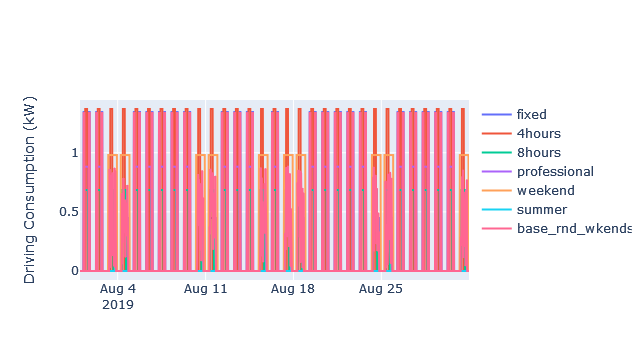

In [8]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot({
    "data": [go.Scatter(x=d.index, y=d['fixed'], name ='fixed'),
             go.Scatter(x=d.index, y=d['4'], name = '4hours'),
             go.Scatter(x=d.index, y=d['8'], name = '8hours'),
             go.Scatter(x=d.index, y=d['professional'], name = 'professional'),
             go.Scatter(x=d.index, y=d['weekend'], name = 'weekend'),
             go.Scatter(x=d.index, y=d['summer'], name = 'summer'),
             go.Scatter(x=d.index, y=d['base_random_weekends'], name = 'base_rnd_wkends')
            ],
    "layout": go.Layout(yaxis=dict(title="Driving Consumption (kW)"))
})

### Driving Pattern Analysis 

In [11]:
s = pd.read_hdf('ds.h5', key = 's')
d = pd.read_hdf('ds.h5', key = 'd')

In [12]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

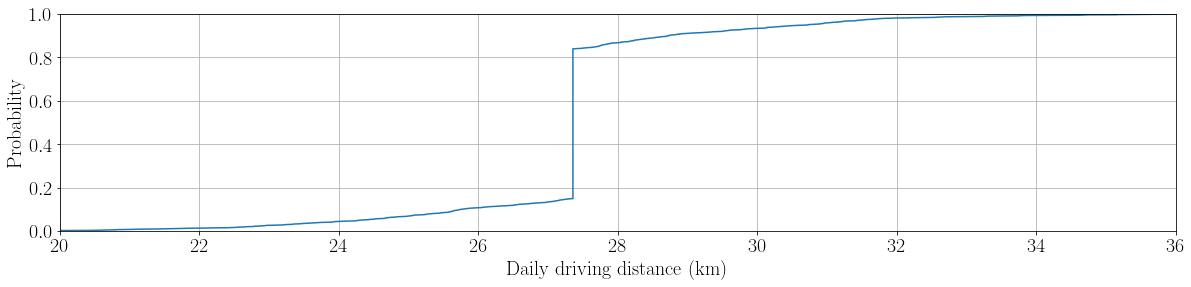

In [14]:
# daily_driving distance_base_random_weekends
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
fig = plt.figure(figsize=[20, 4])
plt.rcParams.update({'font.size': 20})
dr = d.base_random_weekends.resample('D').sum().sort_values()*dt
plt.plot(dr / kWh_per_km, np.arange(1/(2*len(dr)), 1, 1/len(dr)), linewidth = 1.5)
plt.xlim([20, 36])
plt.ylim(0,1)
plt.grid()
plt.xlabel('Daily driving distance (km)')
plt.ylabel('Probability')
fig.savefig('daily_driving_distance_base_random_weekends.pdf',bbox_inches='tight')

In [ ]:
# availability profile
t_lim = pd.date_range('01-07-2019 00:00:00', '01-14-2019 00:00:00', freq='30min')
t = pd.date_range('01-07-2019 00:00:00', '01-13-2019 23:30:00', freq='30min')

rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
fig = plt.figure(figsize=[20, 4])
plt.rcParams.update({'font.size': 20})

ss = sum(s.loc[t, v] for v in ['fixed', 'professional', 'weekend', 'summer', 'base_random_weekends'])
# plt.step(t, ss, linewidth = 1.5, color = 'tab:blue', where = 'post')
#plt.step(t, s.loc[t, 'weekend'], linewidth = 1.5, color = 'tab:orange', where = 'post')
plt.fill_between(t, sum(s.loc[t, v] for v in ['professional', 'weekend', 'summer', 'fixed', 'base_random_weekends']), 
                 sum(s.loc[t, v] for v in ['professional', 'weekend', 'summer']),
                 step='post', color = 'tab:purple', alpha = 0.5, label = "base")
plt.fill_between(t, sum(s.loc[t, v] for v in ['professional', 'weekend', 'summer']), 
                 sum(s.loc[t, v] for v in ['weekend', 'summer']),
                 step='post', color = 'tab:green', alpha = 0.5, label = "professional")
plt.fill_between(t, sum(s.loc[t, v] for v in ['weekend', 'summer']), s.loc[t, 'summer'], step='post', color = 'tab:blue', alpha = 0.5, label = "weekend")
plt.fill_between(t, s.loc[t, 'summer'], y2=0, step='post', color = 'tab:orange', alpha = 0.5, label = "summer")

Tres = '6H'
idx = pd.date_range('01-07-2019 00:00:00', '01-14-2019 00:00:00', freq=Tres).strftime('%H').tolist()
plt.xticks(pd.date_range('01-07-2019 00:00:00', '01-14-2019 00:00:00', freq= Tres), idx)
plt.yticks([0,1,2,3,4,5])
plt.xlim(t_lim[0], t_lim[-1])
plt.ylim(-0,5.25)
plt.grid(linewidth = 0.5)
plt.legend(title = 'Vehicle type', bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('January 7--13, 2019')
plt.ylabel('\# connected vehicles')
fig.savefig('connected_vehicles.pdf',bbox_inches='tight')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
